In [3]:
import re
import nltk
# to show progress bar
from tqdm import tqdm
# for pretty printing
import pprint
import spacy
import pandas as pd 
from itertools import chain
from collections import Counter
from nltk.corpus import stopwords
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))
nlp = spacy.load("es_core_news_sm")

# for topic modelling
from gensim import corpora
from gensim.models import ldamodel
from gensim.models import CoherenceModel

# for data viz
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns


posts_x = pd.read_csv("/home/cygnus/Documentos/khorda_data/lomeli/general/posts_result_x.csv", usecols=["texto", "polaridad"])
posts_insta = pd.read_csv("/home/cygnus/Documentos/khorda_data/lomeli/general/posts_result_insta.csv", usecols=["texto", "polaridad"])
posts_tiktok = pd.read_csv("/home/cygnus/Documentos/khorda_data/lomeli/general/posts_result_tiktok.csv")
posts_fb = pd.read_csv("/home/cygnus/Documentos/khorda_data/lomeli/general/posts_result_fb.csv", usecols=["texto", "polaridad"])

df_coments = pd.concat([posts_x, posts_fb, posts_insta, posts_tiktok], axis=0)
df_polaridad = pd.DataFrame(df_coments["polaridad"].copy())
df_coments = pd.DataFrame(df_coments["texto"].copy())
df_coments

[nltk_data] Downloading package stopwords to /home/cygnus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,texto
0,me siento profundamente orgulloso de ser parte...
1,mi compromiso es estar cerca de ustedes cada f...
2,me considero un líder capaz comprometido y val...
3,agradezco infinitamente el apoyo de quienes co...
4,han sido casi 20 años de lucha esfuerzo y dedi...
...,...
68,"No me gusta, me encanta!!! #DrCarlosLomeli #D..."
69,Es un honor estar con Obrador! 🙌🏻 #DrCarlosLom...
70,Es que si está muy buena la canción 😅 #DrCarlo...
71,¡Feliz cumple 481 Guadalajara querida! #SanVal...


In [4]:
def data_clean(df):
    """
    Parameters
    ----------
    df : DataFrame con columnas
            'texto','comentarisos'repost', 'likes','views'.
    Returns
    -------
    df_posts : DataFrame
        Retorna dos DataFrames limpios:
            El primero con las columnas 'coment','rt','like','views'.
            El segundo con las columnas 'texto', 'tokens'.
    """
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'\d', '', str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'[.,;!?]', '', str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'jaja(ja)*', '', str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r"(, '[\W\.]')",r"", str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
    df = df.fillna('')
    return df

df_coments= data_clean(df_coments)
df_coments

,texto
0,me siento profundamente orgulloso de ser parte...
1,mi compromiso es estar cerca de ustedes cada f...
2,me considero un líder capaz comprometido y val...
3,agradezco infinitamente el apoyo de quienes co...
4,han sido casi años de lucha esfuerzo y dedica...
...,...
68,no me gusta me encanta drcarloslomeli drcarlo...
69,es un honor estar con obrador drcarloslomeli ...
70,es que si está muy buena la canción drcarlosl...
71,feliz cumple guadalajara querida sanvalentin ...


In [5]:
nlp.disable_pipes('ner')
print(nlp.pipe_names)
dataset = df_coments['texto']
docs = []
for text in tqdm(nlp.pipe(dataset), total=len(dataset)):
    doc = nlp(text) 
    pt = [token.lemma_.lower() for token in doc if
           (len(token.lemma_) > 1 and token.pos_ == "NOUN" and 
          not token.is_stop)]
    docs.append(pt)
counts_word_occurence = Counter(chain(*[x for x in docs]))
low_freq_words = {key:value for (key,value) in counts_word_occurence.items() if value==1}
docs = [[lemma for lemma in text if counts_word_occurence[lemma]>1] for text in docs]  
docs_length=len(docs)
counts_word_percentage = Counter(chain(*[set(x) for x in docs]))
counts_word_percentage = {key:(value/docs_length)*100 for (key,value) in counts_word_percentage.items()}
high_freq_words = {key:value for (key,value) in counts_word_percentage.items() if value>4}
docs =  [[lemma for lemma in text if counts_word_percentage[lemma]<4] for text in docs]


/home/cygnus/.local/lib/python3.11/site-packages/spacy/language.py:1067: DeprecationWarning: [W096] The method `nlp.disable_pipes` is now deprecated - use `nlp.select_pipes` instead.
  warnings.warn(Warnings.W096, DeprecationWarning)


['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer']


100%|█████████████████████████████████████████| 359/359 [00:03<00:00, 99.41it/s]


/home/cygnus/.local/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


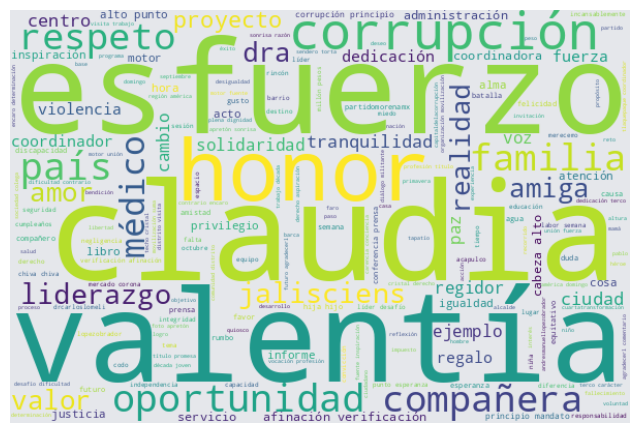

In [8]:
######Nube de Palabras########################
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Limpieza de Stop_words
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as", "aquí", "hacia","dra", "día","hoy","dd","drcarloslomeli","jajaja"
                "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da","doccast","vas","jajajaja","dio","par",
                "drcarloslomeli", "doc", "dr", "jajajajajajaja", "vez", "dra"))

docs = [word for word in docs if word not in stop_words]
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in docs for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)

# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)
# Cículo
# Crear una máscara en blanco para establecer un fondo transparente

# Crear el objeto WordCloud
wordcloud = WordCloud(width=600, height=400, background_color="#e5e7eb").generate(texto)
# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(8, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.savefig("posts.png", dpi=200, bbox_inches="tight")
plt.show()

In [39]:

def generar_bigramas_spacy(texto):
    doc = nlp(texto)
    bigramas = [(doc[i].text, doc[i + 1].text) for i in range(len(doc) - 1)]
    return bigramas



df_coments['bigramas_spacy'] = df_coments['texto'].apply(generar_bigramas_spacy)


from nltk.collocations import *

flatten_corpus = [w for l in df_coments.bigramas_spacy for w in l]

treshold = 4

bigrams = [bigram for bigram in flatten_corpus if len(bigram[0])>treshold and len(bigram[1])>treshold]

bigram_measure = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(bigrams)
finder.apply_freq_filter(2)
colocaciones = finder.nbest(bigram_measure.pmi, 10)
print(type(colocaciones))
colocaciones = pd.DataFrame(colocaciones, columns=['Columna1', 'Columna2'])

colocaciones["colocacion"] = colocaciones.Columna1 + ' ' + colocaciones.Columna2
columnas = ['Columna1', 'Columna2']
colocaciones = colocaciones.drop(columnas, axis=1)
colocaciones

<class 'list'>


,colocacion
0,bicicleta gustan
1,causado fallecimientos
2,detección temprana
3,establecer comités
4,genuino interés
5,hombre honesto
6,institución académica
7,mañana participé
8,querido debido
9,rebaño sagrado


[['hombre', 'proyecto', 'cuartatransformación'],
 ['foto', 'apretón', 'sonrisa', 'razón'],
 ['líder', 'desafío', 'dificultad', 'contrario', 'encaro', 'determinación',
  'motor', 'unión', 'fuerza'],
 [], ['esfuerzo', 'dedicación', 'terco', 'carácter', 'valentía', 'honor'],
 ['amor'], ['felicidad', 'alma'],
 ['vocación', 'profesión', 'título', 'promesa', 'salud', 'médico', 'valentía',
  'valor', 'médico', 'sociedad', 'colega'],
 ['birria', 'barca', 'panza'], ['sendero'], ['torta'],
 ['felicitación', 'amiga', 'compañera', 'motivo', 'cumpleaños', 'cumpleaños'],
 ['tlaquepaque', 'coordinador', 'amor'],
 ['techo', 'cristal', 'derecho', 'aspiración'],
 ['partidomorenamx', 'invitación'],
 ['respeto', 'integridad', 'labor', 'semana'],
 ['alto', 'región', 'américa', 'domingo'], ['privilegio'],
 ['oriente', 'paz', 'tranquilidad', 'desarrollo', 'simpatizante', 'partido'],
 [],
 ['principio', 'partidomorenamx', 'organización', 'movilización', 'suma',
  'voluntad', 'causa', 'equitativo'],
 ['resulta

/usr/lib/python3/dist-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/usr/lib/python3/dist-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/usr/lib/python3/dist-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/usr/lib/python3/dist-packag

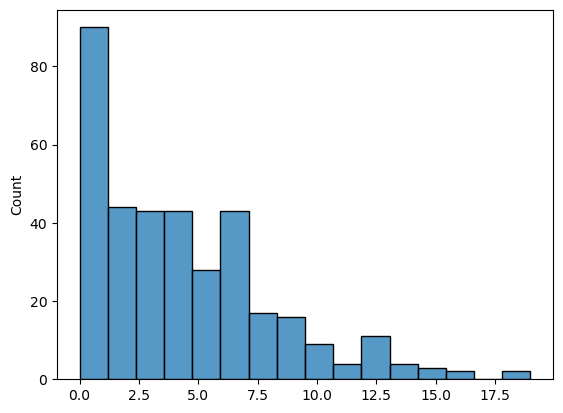

In [37]:
###############################################
pp = pprint.PrettyPrinter(compact=True)
pp.pprint(docs)
lengths =  [len(x) for x in docs]
sns.histplot(lengths)
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]

def calculate_coherence(dictionary, corpus, docs, start, stop):
    scores = []
    for topics in range(start, stop):

        # defining the model
        lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=26, alpha='auto', eval_every=5)

        # U_mass coherence score
        cm_u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        u_mass_coherence = cm_u_mass.get_coherence()

        # C_v coherence score
        cm_c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
        c_v_coherence = cm_c_v.get_coherence()

        values = [topics, u_mass_coherence, c_v_coherence]

        scores.append(values)

    return scores

scores = calculate_coherence(dictionary, corpus, docs, 10, 30)
df = pd.DataFrame(scores, columns = ['number_of_topics','u_mass_coherence','c_v_coherence'])
df = df.melt(id_vars=['number_of_topics'], value_vars=['u_mass_coherence','c_v_coherence'])

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

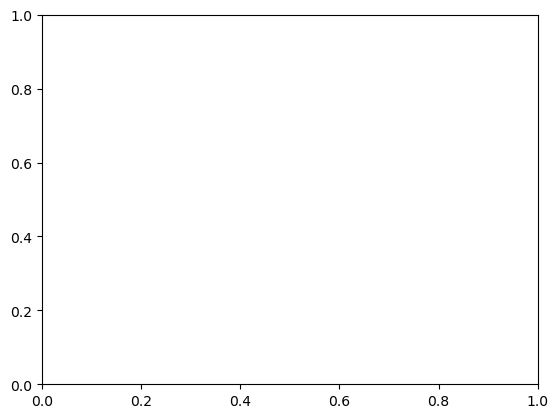

In [46]:
# Plotting u_mass_coherence
sns.lineplot(data=df.loc[df['variable'] == 'c_v_coherence'], x="number_of_topics", y="value").set_title('c_v coherence')


In [42]:
###########Modelo LDA Topics##########################
lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, alpha='auto', eval_every=5)

# print topics
lda_model.print_topics(-1)


# print topics
topics = lda_model.print_topics(-1)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

########################################
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(viz, 'ldavis_visualization_posts.html')

(0, '0.030*"compañera" + 0.025*"oportunidad" + 0.020*"proyecto" + 0.020*"batalla" + 0.020*"domingo" + 0.017*"liderazgo" + 0.015*"valentía" + 0.015*"felicidad" + 0.015*"semana" + 0.015*"tiempo"')
(1, '0.050*"verificación" + 0.039*"afinación" + 0.021*"agua" + 0.017*"informe" + 0.017*"compañera" + 0.017*"recorrido" + 0.017*"ejemplo" + 0.017*"cosa" + 0.016*"peso" + 0.012*"hijo"')
(2, '0.027*"médico" + 0.022*"corrupción" + 0.022*"amistad" + 0.022*"amor" + 0.021*"salud" + 0.018*"valentía" + 0.018*"abrazo" + 0.018*"vuelta" + 0.014*"peso" + 0.014*"sociedad"')
(3, '0.027*"violencia" + 0.027*"cambio" + 0.022*"esperanza" + 0.018*"honor" + 0.018*"voz" + 0.018*"hora" + 0.014*"corrupción" + 0.014*"ojo" + 0.014*"diálogo" + 0.014*"familia"')
(4, '0.038*"fuerza" + 0.030*"motor" + 0.023*"desafío" + 0.023*"encaro" + 0.023*"dificultad" + 0.023*"unión" + 0.023*"determinación" + 0.023*"líder" + 0.023*"contrario" + 0.015*"labor"')
(5, '0.020*"tranquilidad" + 0.020*"familia" + 0.016*"corrupción" + 0.016*"duda

In [43]:
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.016648 -0.097254       1        1  12.564104
6     -0.106858  0.139870       2        1  12.333667
5     -0.017186 -0.121016       3        1  11.533901
8      0.078355  0.130123       4        1  10.919342
1      0.138357 -0.017590       5        1  10.361881
4     -0.047147  0.062909       6        1   9.380223
9     -0.127593 -0.072575       7        1   9.286275
0      0.106717  0.057274       8        1   9.066769
7      0.078513 -0.078036       9        1   7.877667
2     -0.119805 -0.003705      10        1   6.676171, topic_info=             Term       Freq      Total Category  logprob  loglift
71      principio  12.000000  12.000000  Default  30.0000  30.0000
344  verificación  12.000000  12.000000  Default  29.0000  29.0000
242          país  12.000000  12.000000  Default  28.0000  28.0000
349     afinación   7.000000   7.000000  Default  27.0000  27.0000
12         fuerza  10.000000  10.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
204    corrupción   2.323163  16.445837  Topic10  -3.8067   0.7495
32          valor   1.412124   8.308822  Topic10  -4.3046   0.9344
48        derecho   1.412085   8.396763  Topic10  -4.3046   0.9238
71      principio   1.412154  12.614625  Topic10  -4.3045   0.5169
236       claudia   1.412036  12.922171  Topic10  -4.3046   0.4927

[482 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
337       6  0.267260    abrazo
337      10  0.534520    abrazo
254       1  0.573951  acapulco
254      10  0.286976  acapulco
255       1  0.462710    acopio
...     ...       ...       ...
182      10  0.534508    vuelta
169       3  0.680134      zona
162       4  0.271054     éxito
162       5  0.271054     éxito
162       6  0.271054     éxito

[815 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 6, 9, 2, 5, 10, 1, 8, 3])

In [44]:

topic_data = []
for topic_id, topic in topics:
    topic_words = [word.split('*')[1] for word in topic.split('+')]
    topic_data.append([topic_id, ", ".join(topic_words)])

# DataFrame a partir de los datos de tópicos
df_topics = pd.DataFrame(topic_data, columns=["ID de Tópico", "Palabras Clave"])

freq = viz[0]

topicos = pd.concat([df_topics, freq, colocaciones], axis=1)
topicos.to_csv("topicos_posts.csv")
topicos

,ID de Tópico,Palabras Clave,x,y,topics,cluster,Freq,colocacion
0,0,"""compañera"" , ""oportunidad"" , ""proyecto"" , ""ba...",0.106717,0.057274,8,1,9.066769,bicicleta gustan
1,1,"""verificación"" , ""afinación"" , ""agua"" , ""infor...",0.138357,-0.017590,5,1,10.361881,causado fallecimientos
2,2,"""médico"" , ""corrupción"" , ""amistad"" , ""amor"" ,...",-0.119805,-0.003705,10,1,6.676171,detección temprana
3,3,"""violencia"" , ""cambio"" , ""esperanza"" , ""honor""...",0.016648,-0.097254,1,1,12.564104,establecer comités
4,4,"""fuerza"" , ""motor"" , ""desafío"" , ""encaro"" , ""d...",-0.047147,0.062909,6,1,9.380223,genuino interés
5,5,"""tranquilidad"" , ""familia"" , ""corrupción"" , ""d...",-0.017186,-0.121016,3,1,11.533901,hombre honesto
6,6,"""inspiración"" , ""liderazgo"" , ""claudia"" , ""dra...",-0.106858,0.139870,2,1,12.333667,institución académica
7,7,"""paz"" , ""privilegio"" , ""chiva"" , ""causa"" , ""pr...",0.078513,-0.078036,9,1,7.877667,mañana participé
8,8,"""país"" , ""futuro"" , ""amiga"" , ""proyecto"" , ""ci...",0.078355,0.130123,4,1,10.919342,querido debido
9,9,"""principio"" , ""corrupción"" , ""acto"" , ""oportun...",-0.127593,-0.072575,7,1,9.286275,rebaño sagrado
